<span style='background:#DCEDC8; font-size:30px; display:block; border-left:40px solid #C5E1A5; padding-left:40px;'>
<b>
    Download multiple meteoscreening variables
</b>
</span>

**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

</br>

# **Auto-settings**

## Data settings

In [1]:
DIRCONF = r'L:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution

## Imports

In [2]:
from datetime import datetime
import importlib.metadata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from dbc_influxdb import dbcInflux
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import DetectFrequency
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

ModuleNotFoundError: No module named 'pandas'

</br>

# **Download**

In [4]:
OUTFILE = f"meteo6_2005-2024.csv"

## Download FLUXNET meteo data (2005-2023)

In [5]:
%%time
data_simple_fluxnet, data_detailed_fluxnet, assigned_measurements_fluxnet = dbc.download(
    bucket=f'ch-cha_processed',
    measurements=['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA'],
    fields=['TA_F', 'RH', 'LW_IN_F', 'PPFD_IN', 'SW_IN_F', 'PA_F'],
    start='2005-01-01 00:00:01',  # Download data starting with this date (the start date itself IS included),
    stop='2024-01-01 00:00:01',  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version='fluxnet_v2024'
)


DOWNLOADING
    from bucket ch-cha_processed
    variables ['TA_F', 'RH', 'LW_IN_F', 'PPFD_IN', 'SW_IN_F', 'PA_F']
    from measurements ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
    from data version fluxnet_v2024
    between 2005-01-01 00:00:01 and 2024-01-01 00:00:01
    with timezone offset to UTC of 1
Used querystring: from(bucket: "ch-cha_processed") |> range(start: 2005-01-01T00:00:01+01:00, stop: 2024-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "LW" or r["_measurement"] == "PPFD" or r["_measurement"] == "SW" or r["_measurement"] == "PA") |> filter(fn: (r) => r["data_version"] == "fluxnet_v2024") |> filter(fn: (r) => r["_field"] == "TA_F" or r["_field"] == "RH" or r["_field"] == "LW_IN_F" or r["_field"] == "PPFD_IN" or r["_field"] == "SW_IN_F" or r["_field"] == "PA_F") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
querystring was constructed from:
    bucketstring: from(bucket:

In [6]:
data_simple_fluxnet

,LW_IN_F,PA_F,PPFD_IN,RH,SW_IN_F,TA_F
TIMESTAMP_END,,,,,,
2005-01-01 00:30:00,331.462,98.160,NaN,NaN,0.0,2.241
2005-01-01 01:00:00,331.462,98.163,NaN,NaN,0.0,2.273
2005-01-01 01:30:00,330.270,98.167,NaN,NaN,0.0,2.305
2005-01-01 02:00:00,330.270,98.173,NaN,NaN,0.0,2.284
2005-01-01 02:30:00,323.555,98.180,NaN,NaN,0.0,2.264
...,...,...,...,...,...,...
2023-12-31 22:00:00,327.407,96.497,0.0,99.5571,0.0,1.541
2023-12-31 22:30:00,327.958,96.505,0.0,98.9703,0.0,2.052
2023-12-31 23:00:00,328.606,96.526,0.0,97.6652,0.0,2.223


## Download newest meteo data from diive meteoscreening (2024)

In [7]:
%%time
data_simple, data_detailed, assigned_measurements = dbc.download(
    bucket=f'ch-cha_processed',
    measurements=['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA'],
    fields=['TA_T1_2_1', 'RH_T1_2_1', 'LW_IN_T1_2_1', 'PPFD_IN_T1_2_2', 'SW_IN_T1_2_1', 'PA_GF1_0.9_1'],
    start='2024-01-01 00:00:01',  # Download data starting with this date (the start date itself IS included),
    stop='2025-01-01 00:00:01',  # Download data before this date (the stop date itself IS NOT included),
    timezone_offset_to_utc_hours=TIMEZONE_OFFSET_TO_UTC_HOURS,
    data_version='meteoscreening_diive'
)


DOWNLOADING
    from bucket ch-cha_processed
    variables ['TA_T1_2_1', 'RH_T1_2_1', 'LW_IN_T1_2_1', 'PPFD_IN_T1_2_2', 'SW_IN_T1_2_1', 'PA_GF1_0.9_1']
    from measurements ['TA', 'RH', 'LW', 'PPFD', 'SW', 'PA']
    from data version meteoscreening_diive
    between 2024-01-01 00:00:01 and 2025-01-01 00:00:01
    with timezone offset to UTC of 1
Used querystring: from(bucket: "ch-cha_processed") |> range(start: 2024-01-01T00:00:01+01:00, stop: 2025-01-01T00:00:01+01:00) |> filter(fn: (r) => r["_measurement"] == "TA" or r["_measurement"] == "RH" or r["_measurement"] == "LW" or r["_measurement"] == "PPFD" or r["_measurement"] == "SW" or r["_measurement"] == "PA") |> filter(fn: (r) => r["data_version"] == "meteoscreening_diive") |> filter(fn: (r) => r["_field"] == "TA_T1_2_1" or r["_field"] == "RH_T1_2_1" or r["_field"] == "LW_IN_T1_2_1" or r["_field"] == "PPFD_IN_T1_2_2" or r["_field"] == "SW_IN_T1_2_1" or r["_field"] == "PA_GF1_0.9_1") |> pivot(rowKey:["_time"], columnKey: ["_field"],

In [8]:
data_simple

,LW_IN_T1_2_1,PA_GF1_0.9_1,PPFD_IN_T1_2_2,RH_T1_2_1,SW_IN_T1_2_1,TA_T1_2_1
TIMESTAMP_END,,,,,,
2024-01-01 00:30:00,327.413890,965.804617,0.0,96.860653,0.0,2.004806
2024-01-01 01:00:00,326.428353,965.977447,0.0,97.769545,0.0,1.458978
2024-01-01 01:30:00,323.743830,965.748550,0.0,99.497774,0.0,0.816056
2024-01-01 02:00:00,321.212440,965.525673,0.0,99.997990,0.0,-0.043878
2024-01-01 02:30:00,318.915697,965.454533,0.0,99.997990,0.0,-0.844900
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,983.370890,0.0,99.997990,0.0,-1.919472
2024-12-31 22:30:00,303.039890,983.052160,0.0,99.997990,0.0,-2.104678
2024-12-31 23:00:00,302.093633,982.851140,0.0,99.997990,0.0,-2.089444


</br>

# **Adjust units** (if needed)

In [9]:
# Units for PA from meteoscreening_diive are given in mbar (hPa), but are needed in kPa
data_simple['PA_GF1_0.9_1'] = data_simple['PA_GF1_0.9_1'].divide(10)
data_simple

,LW_IN_T1_2_1,PA_GF1_0.9_1,PPFD_IN_T1_2_2,RH_T1_2_1,SW_IN_T1_2_1,TA_T1_2_1
TIMESTAMP_END,,,,,,
2024-01-01 00:30:00,327.413890,96.580462,0.0,96.860653,0.0,2.004806
2024-01-01 01:00:00,326.428353,96.597745,0.0,97.769545,0.0,1.458978
2024-01-01 01:30:00,323.743830,96.574855,0.0,99.497774,0.0,0.816056
2024-01-01 02:00:00,321.212440,96.552567,0.0,99.997990,0.0,-0.043878
2024-01-01 02:30:00,318.915697,96.545453,0.0,99.997990,0.0,-0.844900
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,98.337089,0.0,99.997990,0.0,-1.919472
2024-12-31 22:30:00,303.039890,98.305216,0.0,99.997990,0.0,-2.104678
2024-12-31 23:00:00,302.093633,98.285114,0.0,99.997990,0.0,-2.089444


</br>

# **Rename variables for merging and for use in EddyPro**

In [10]:
renaming_dict = {
    'LW_IN_F': 'Lwin_1_1_1',
    'PPFD_IN': 'PPFD_1_1_1',
    'RH': 'RH_1_1_1',
    'SW_IN_F': 'Rg_1_1_1',
    'TA_F': 'Ta_1_1_1',
    'PA_F': 'Pa_1_1_1'
}
data_simple_fluxnet = data_simple_fluxnet.rename(columns=renaming_dict)
data_simple_fluxnet

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2005-01-01 00:30:00,331.462,98.160,NaN,NaN,0.0,2.241
2005-01-01 01:00:00,331.462,98.163,NaN,NaN,0.0,2.273
2005-01-01 01:30:00,330.270,98.167,NaN,NaN,0.0,2.305
2005-01-01 02:00:00,330.270,98.173,NaN,NaN,0.0,2.284
2005-01-01 02:30:00,323.555,98.180,NaN,NaN,0.0,2.264
...,...,...,...,...,...,...
2023-12-31 22:00:00,327.407,96.497,0.0,99.5571,0.0,1.541
2023-12-31 22:30:00,327.958,96.505,0.0,98.9703,0.0,2.052
2023-12-31 23:00:00,328.606,96.526,0.0,97.6652,0.0,2.223


In [11]:
renaming_dict = {
    'LW_IN_T1_2_1': 'Lwin_1_1_1',
    'PPFD_IN_T1_2_2': 'PPFD_1_1_1',
    'RH_T1_2_1': 'RH_1_1_1',
    'SW_IN_T1_2_1': 'Rg_1_1_1',
    'TA_T1_2_1': 'Ta_1_1_1',
    'PA_GF1_0.9_1': 'Pa_1_1_1'
}
data_simple = data_simple.rename(columns=renaming_dict)
data_simple

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2024-01-01 00:30:00,327.413890,96.580462,0.0,96.860653,0.0,2.004806
2024-01-01 01:00:00,326.428353,96.597745,0.0,97.769545,0.0,1.458978
2024-01-01 01:30:00,323.743830,96.574855,0.0,99.497774,0.0,0.816056
2024-01-01 02:00:00,321.212440,96.552567,0.0,99.997990,0.0,-0.043878
2024-01-01 02:30:00,318.915697,96.545453,0.0,99.997990,0.0,-0.844900
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,98.337089,0.0,99.997990,0.0,-1.919472
2024-12-31 22:30:00,303.039890,98.305216,0.0,99.997990,0.0,-2.104678
2024-12-31 23:00:00,302.093633,98.285114,0.0,99.997990,0.0,-2.089444


</br>

# **Merge data**

In [12]:
# Merge data on index
data_simple_merged = pd.concat([data_simple_fluxnet, data_simple], axis=0)
data_simple_merged

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2005-01-01 00:30:00,331.462000,98.160000,NaN,NaN,0.0,2.241000
2005-01-01 01:00:00,331.462000,98.163000,NaN,NaN,0.0,2.273000
2005-01-01 01:30:00,330.270000,98.167000,NaN,NaN,0.0,2.305000
2005-01-01 02:00:00,330.270000,98.173000,NaN,NaN,0.0,2.284000
2005-01-01 02:30:00,323.555000,98.180000,NaN,NaN,0.0,2.264000
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,98.337089,0.0,99.99799,0.0,-1.919472
2024-12-31 22:30:00,303.039890,98.305216,0.0,99.99799,0.0,-2.104678
2024-12-31 23:00:00,302.093633,98.285114,0.0,99.99799,0.0,-2.089444


</br>

# **Sanitize timestamp**

In [13]:
data_simple_merged = TimestampSanitizer(data=data_simple_merged, output_middle_timestamp=False).get()
data_simple_merged

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1
TIMESTAMP_END,,,,,,
2005-01-01 00:30:00,331.462000,98.160000,NaN,NaN,0.0,2.241000
2005-01-01 01:00:00,331.462000,98.163000,NaN,NaN,0.0,2.273000
2005-01-01 01:30:00,330.270000,98.167000,NaN,NaN,0.0,2.305000
2005-01-01 02:00:00,330.270000,98.173000,NaN,NaN,0.0,2.284000
2005-01-01 02:30:00,323.555000,98.180000,NaN,NaN,0.0,2.264000
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,98.337089,0.0,99.99799,0.0,-1.919472
2024-12-31 22:30:00,303.039890,98.305216,0.0,99.99799,0.0,-2.104678
2024-12-31 23:00:00,302.093633,98.285114,0.0,99.99799,0.0,-2.089444


</br>

# **Gap-filling**

## Rg

In [14]:
_df = pd.DataFrame()
_df['Rg_1_1_1'] = data_simple_merged[['Rg_1_1_1']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

,Rg_1_1_1,SW_IN_POT
TIMESTAMP_END,,
2005-01-01 00:30:00,0.0,0.0
2005-01-01 01:00:00,0.0,0.0
2005-01-01 01:30:00,0.0,0.0
2005-01-01 02:00:00,0.0,0.0
2005-01-01 02:30:00,0.0,0.0
...,...,...
2024-12-31 22:00:00,0.0,0.0
2024-12-31 22:30:00,0.0,0.0
2024-12-31 23:00:00,0.0,0.0


In [15]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='Rg_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=1000,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 350640.


In [16]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 01:00:00 and 2024-12-31 23:30:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:183.75292	validation_1-rmse:183.16999
[1]	validation_0-rmse:152.93842	validation_1-rmse:152.62247
[2]	validation_0-rmse:135.13296	validation_1-rmse:135.06905
[3]	validation_0-rmse:125.27272	validation_1-rmse:125.35587
[4]	validation_0-rmse:119.91777	validation_1-rmse:120.17504
[5]	validation_0-rmse:117.00472	validation_1-rmse:117.40945
[6]	validation_0-rmse:115.48635	validation_1-rmse:116.00856
[7]	validation_0-rmse:114.57194	validation_1-rmse:115.20874
[8]	validation_0-rmse:113.88631	validation_1-rmse:114.60993
[9]	validation_0-rmse:113.37794	validation_1-rmse:114.20044
[10]	validation_0-rmse:113.05250	validation_1-rmse:113.92897
[11]	validation_0-rmse:112.71970	validation_1-rmse:113.61157
[12]	validation_0-rmse:112.43131	validation_1-rmse:113.35489
[13]	validation_0-rmse:1

In [17]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target Rg_1_1_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting Rg_1_1_1 ...
>>> Predicting target Rg_1_1_1 where all features are available ... predicted 350640 records.
>>> Collecting results for final model ...
>>> Filling 13 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable Rg_1_1_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (13 values, Rg_1_1_1_gfXG where flag=1) in comparison to observed targets (350627 values, Rg_1_1_1).

## TARGET
- first timestamp:  2005-01-01 00:30:00
- last timestamp:  2025-01-01 00:00:00
- potential number of values: 350640 values)
- target 

In [18]:
observed = _df['Rg_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

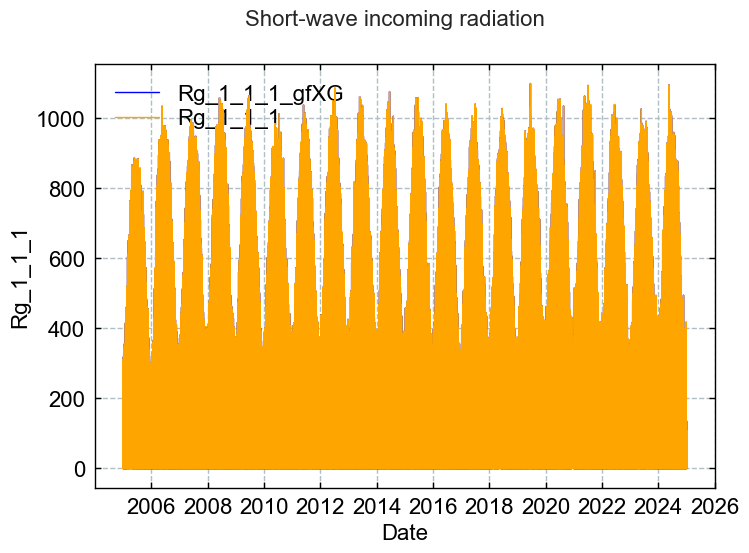

In [19]:
title="Short-wave incoming radiation"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

## TA

In [20]:
_df = pd.DataFrame()
_df['Rg_1_1_1_gfXG'] = data_simple_merged['Rg_1_1_1_gfXG'].copy()
_df['Ta_1_1_1'] = data_simple_merged['Ta_1_1_1'].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

,Rg_1_1_1_gfXG,Ta_1_1_1,SW_IN_POT
TIMESTAMP_END,,,
2005-01-01 00:30:00,0.0,2.241000,0.0
2005-01-01 01:00:00,0.0,2.273000,0.0
2005-01-01 01:30:00,0.0,2.305000,0.0
2005-01-01 02:00:00,0.0,2.284000,0.0
2005-01-01 02:30:00,0.0,2.264000,0.0
...,...,...,...
2024-12-31 22:00:00,0.0,-1.919472,0.0
2024-12-31 22:30:00,0.0,-2.104678,0.0
2024-12-31 23:00:00,0.0,-2.089444,0.0


In [21]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='Ta_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=200,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 350640.


In [22]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-01-01 01:00:00 and 2025-01-01 00:00:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:6.58563	validation_1-rmse:6.57848
[1]	validation_0-rmse:5.35856	validation_1-rmse:5.35302
[2]	validation_0-rmse:4.59739	validation_1-rmse:4.59472
[3]	validation_0-rmse:4.12936	validation_1-rmse:4.12624
[4]	validation_0-rmse:3.85686	validation_1-rmse:3.85702
[5]	validation_0-rmse:3.68221	validation_1-rmse:3.68501
[6]	validation_0-rmse:3.56956	validation_1-rmse:3.57416
[7]	validation_0-rmse:3.50626	validation_1-rmse:3.51392
[8]	validation_0-rmse:3.45645	validation_1-rmse:3.46526
[9]	validation_0-rmse:3.41856	validation_1-rmse:3.42733
[10]	validation_0-rmse:3.39365	validation_1-rmse:3.40340
[11]	validation_0-rmse:3.35313	validation_1-rmse:3.36345
[12]	validation_0-rmse:3.33336	validation_1-rmse:3.34464
[13]	validation_0-rmse:3.31356	validation_1-rmse:3.32583
[14]	validation_0-r

In [23]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target Ta_1_1_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting Ta_1_1_1 ...
>>> Predicting target Ta_1_1_1 where all features are available ... predicted 350640 records.
>>> Collecting results for final model ...
>>> Filling 25 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable Ta_1_1_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (25 values, Ta_1_1_1_gfXG where flag=1) in comparison to observed targets (350615 values, Ta_1_1_1).

## TARGET
- first timestamp:  2005-01-01 00:30:00
- last timestamp:  2025-01-01 00:00:00
- potential number of values: 350640 values)
- target 

In [24]:
observed = _df['Ta_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

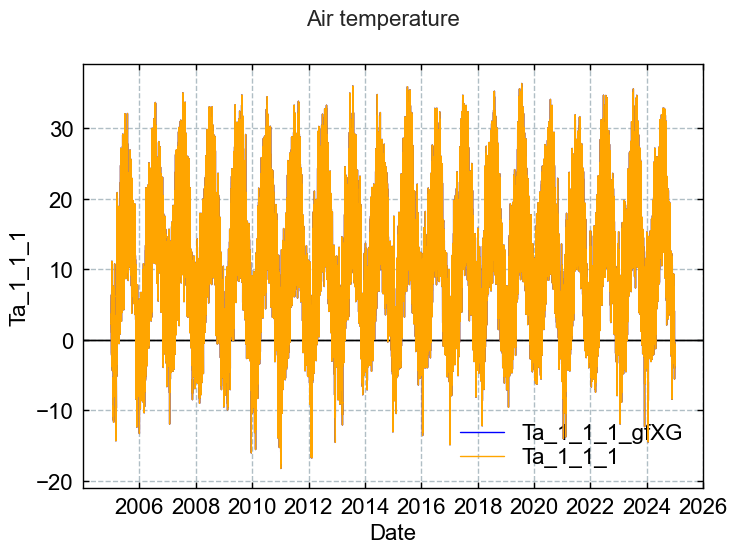

In [25]:
title="Air temperature"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

## PPFD

In [26]:
_df = pd.DataFrame()
_df['PPFD_1_1_1'] = data_simple_merged[['PPFD_1_1_1']].copy()
_df['Rg_1_1_1_gfXG'] = data_simple_merged[['Rg_1_1_1_gfXG']].copy()
_df['SW_IN_POT'] = potrad(timestamp_index=_df.index,
                          lat=47.210227,  # CH-CHA
                          lon=8.410645,  # CH-CHA
                          utc_offset=1)
_df

,PPFD_1_1_1,Rg_1_1_1_gfXG,SW_IN_POT
TIMESTAMP_END,,,
2005-01-01 00:30:00,NaN,0.0,0.0
2005-01-01 01:00:00,NaN,0.0,0.0
2005-01-01 01:30:00,NaN,0.0,0.0
2005-01-01 02:00:00,NaN,0.0,0.0
2005-01-01 02:30:00,NaN,0.0,0.0
...,...,...,...
2024-12-31 22:00:00,0.0,0.0,0.0
2024-12-31 22:30:00,0.0,0.0,0.0
2024-12-31 23:00:00,0.0,0.0,0.0


In [27]:
xgb = XGBoostTS(
    input_df=_df,
    target_col='PPFD_1_1_1',
    perm_n_repeats=10,
    include_timestamp_as_features=True,
    add_continuous_record_number=True,
    n_estimators=200,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)


Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 350640.


In [28]:
xgb.trainmodel(showplot_scores=False, showplot_importance=False)
xgb.report_traintest()


Training final model ...
>>> Training model <class 'xgboost.sklearn.XGBRegressor'> based on data between 2005-09-09 10:30:00 and 2024-12-31 23:30:00 ...
>>> Fitting model to training data ...
[0]	validation_0-rmse:326.27551	validation_1-rmse:325.35112
[1]	validation_0-rmse:229.15994	validation_1-rmse:228.41418
[2]	validation_0-rmse:161.39186	validation_1-rmse:160.74835
[3]	validation_0-rmse:114.25617	validation_1-rmse:113.65303
[4]	validation_0-rmse:81.65777	validation_1-rmse:81.10705
[5]	validation_0-rmse:59.34811	validation_1-rmse:58.79729
[6]	validation_0-rmse:44.34227	validation_1-rmse:43.82627
[7]	validation_0-rmse:34.53873	validation_1-rmse:34.02278
[8]	validation_0-rmse:28.32398	validation_1-rmse:27.79675
[9]	validation_0-rmse:24.54367	validation_1-rmse:24.03895
[10]	validation_0-rmse:22.28900	validation_1-rmse:21.79923
[11]	validation_0-rmse:20.92441	validation_1-rmse:20.45497
[12]	validation_0-rmse:20.08053	validation_1-rmse:19.65291
[13]	validation_0-rmse:19.46727	validation

In [29]:
xgb.fillgaps(showplot_scores=False, showplot_importance=False)
xgb.report_gapfilling()


Gap-filling using final model ...
>>> Using final model on all data to predict target PPFD_1_1_1 ...
>>> Using final model on all data to calculate permutation importance ...
>>> Calculating prediction scores based on all data predicting PPFD_1_1_1 ...
>>> Predicting target PPFD_1_1_1 where all features are available ... predicted 350640 records.
>>> Collecting results for final model ...
>>> Filling 16688 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable PPFD_1_1_1_gfXG ...
>>> Restoring original timestamp in results ...
>>> Combining predictions from full model and fallback model ...

GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (16688 values, PPFD_1_1_1_gfXG where flag=1) in comparison to observed targets (333952 values, PPFD_1_1_1).

## TARGET
- first timestamp:  2005-01-01 00:30:00
- last timestamp:  2025-01-01 00:00:00
- potential number of values: 350640

In [30]:
observed = _df['PPFD_1_1_1']
gapfilled = xgb.get_gapfilled_target()
data_simple_merged[gapfilled.name] = gapfilled

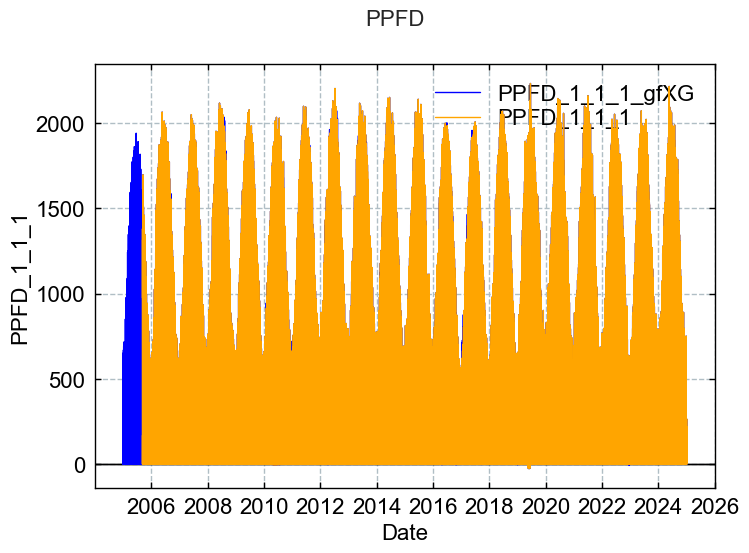

In [31]:
title="PPFD"
fig, ax = plt.subplots()
TimeSeries(series=gapfilled, ax=ax).plot(color='blue')
TimeSeries(series=observed, ax=ax).plot(color='orange')
fig.suptitle(f'{title}', fontsize=16)
# ax.set_ylim(-2000, 200)
fig.show()

</br>

# **Plots**

In [32]:
_plot_df = data_simple_merged[['Lwin_1_1_1', 'PPFD_1_1_1', 'PPFD_1_1_1_gfXG', 'RH_1_1_1', 'Rg_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1', 'Ta_1_1_1_gfXG', 'Pa_1_1_1']].copy()
_plot_df = _plot_df.replace(-9999, np.nan)

## Time series plot

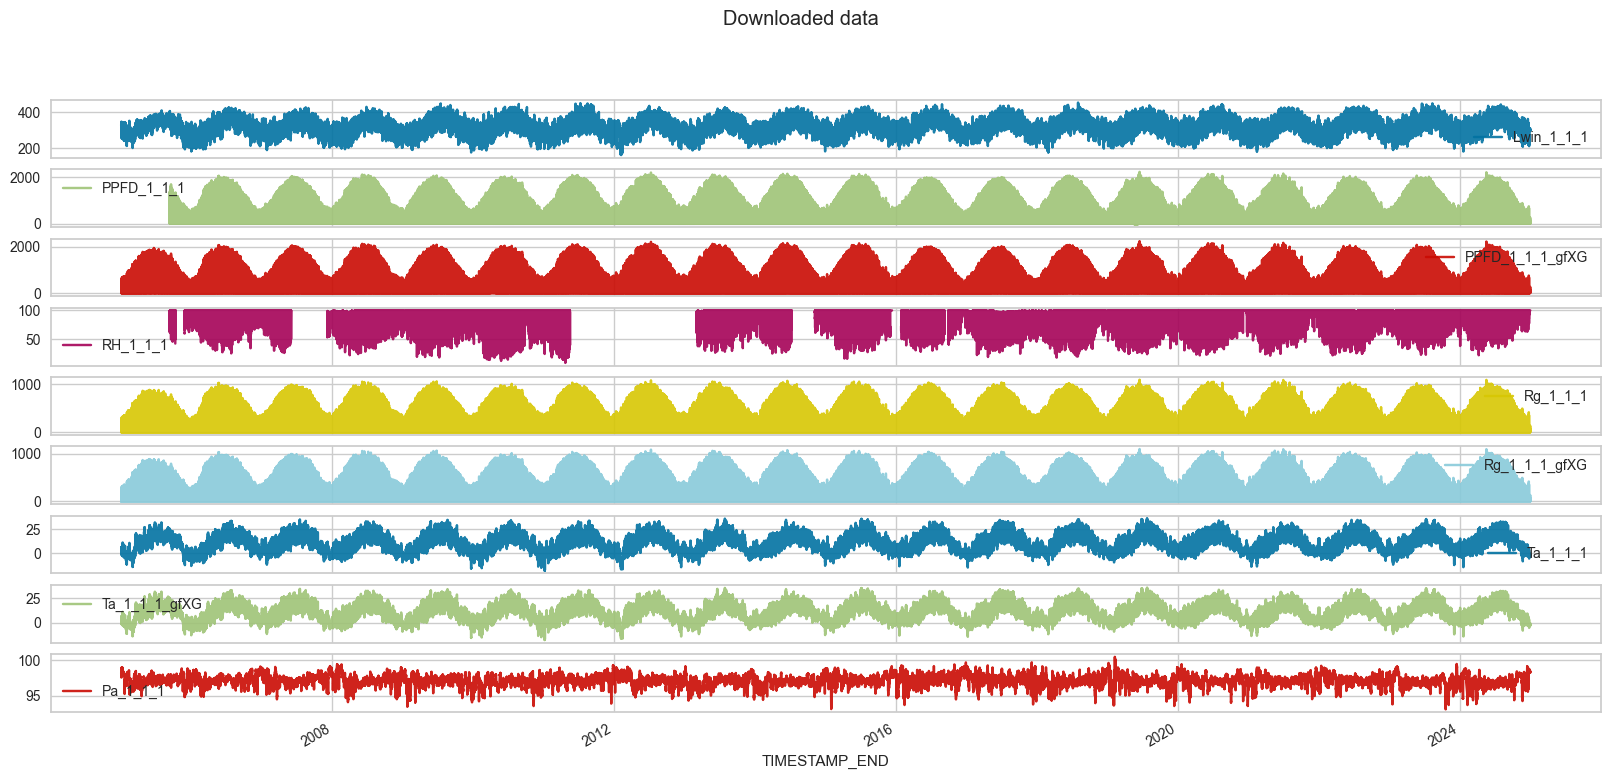

In [33]:
_plot_df.plot(subplots=True, figsize=(20, 9), title="Downloaded data", alpha=.9, x_compat=True);

## Heatmaps

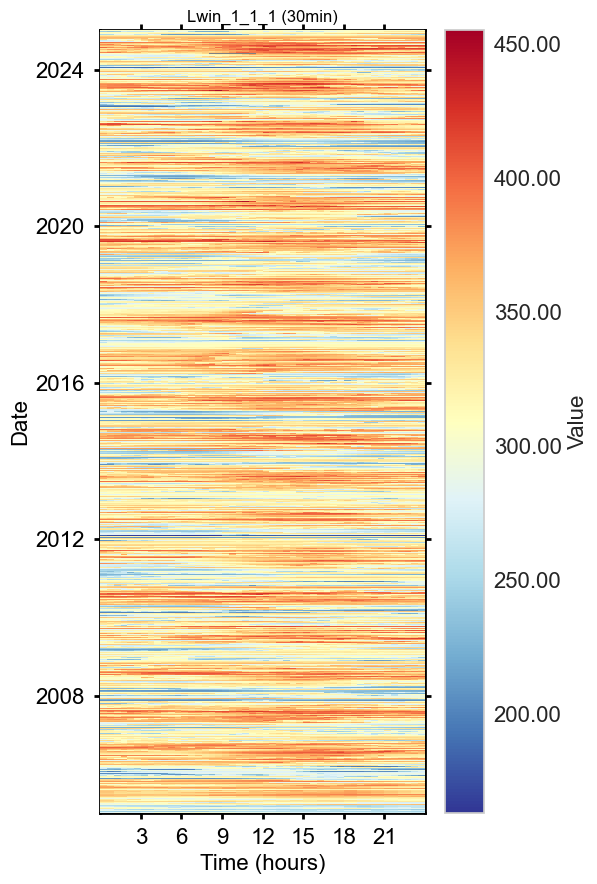

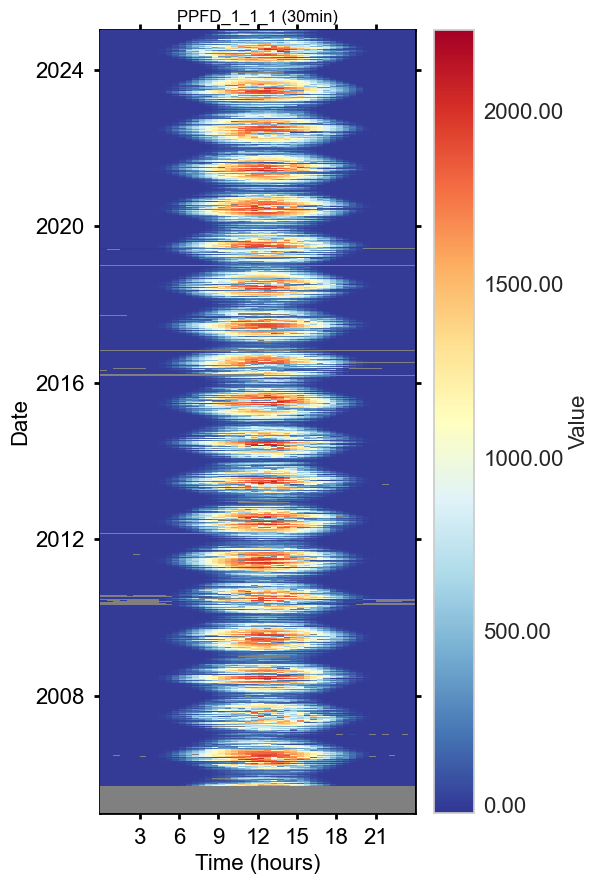

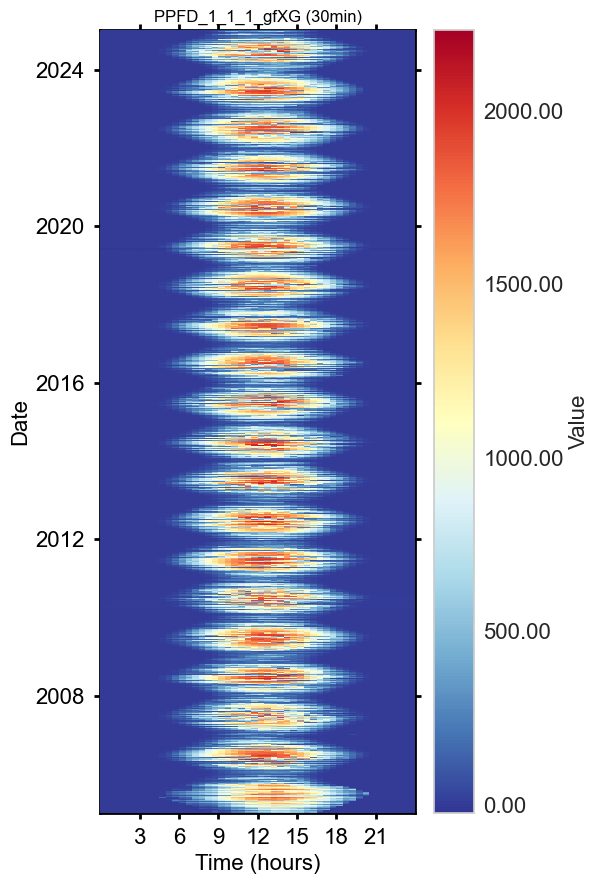

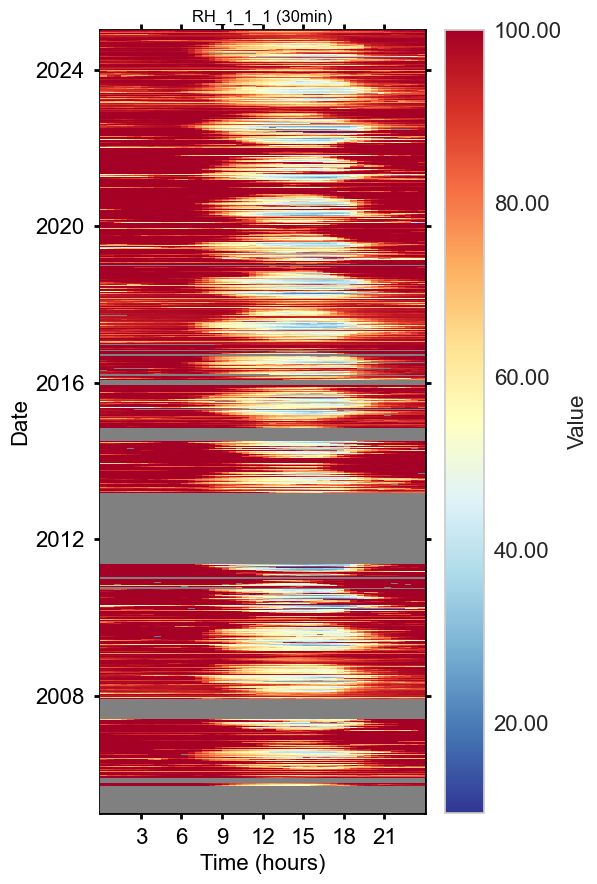

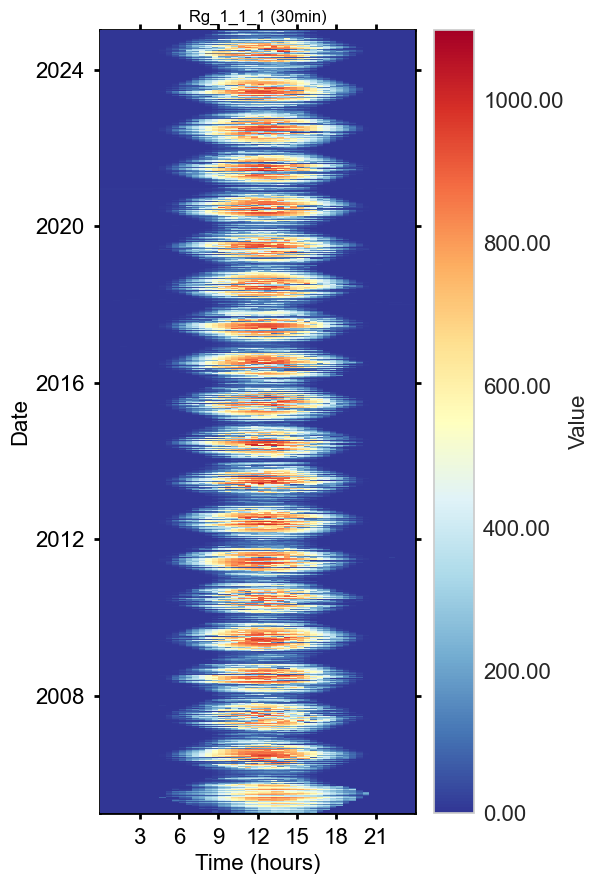

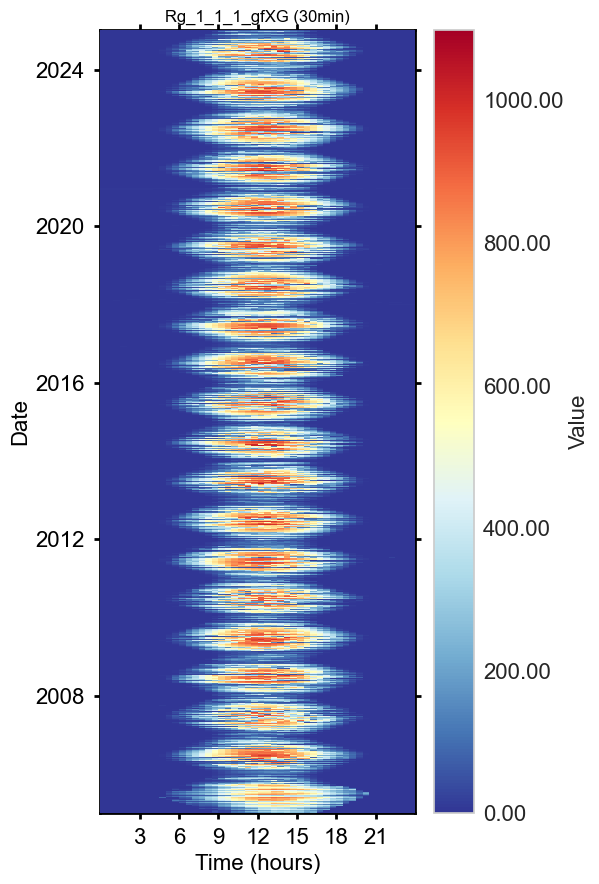

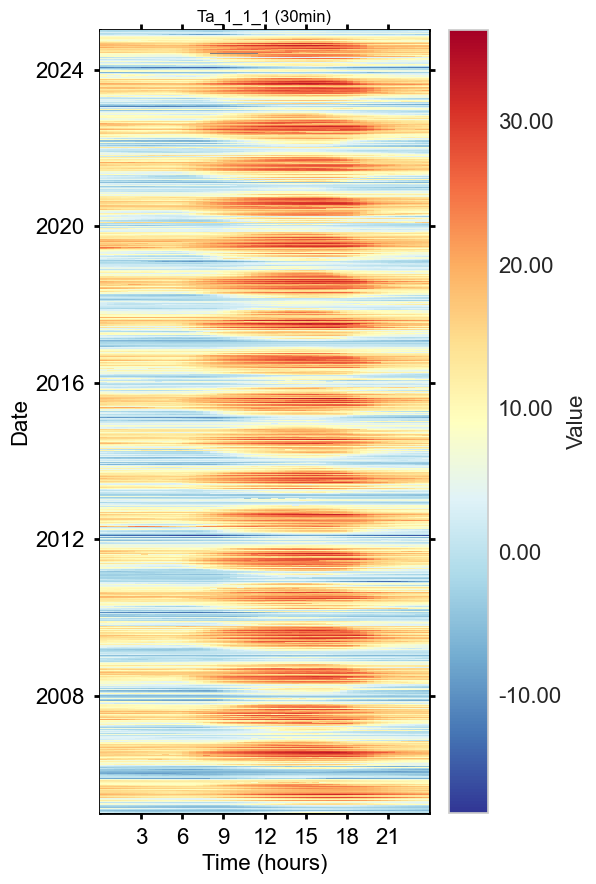

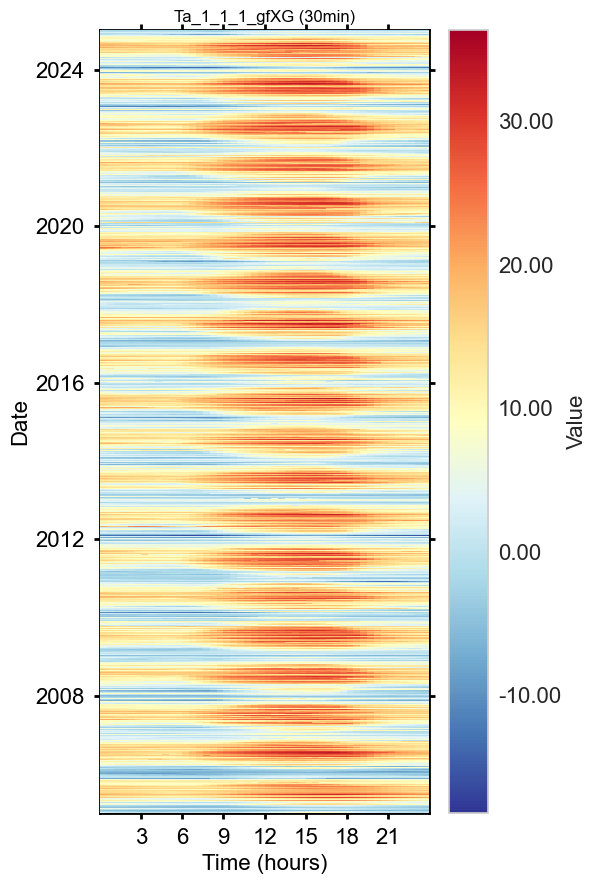

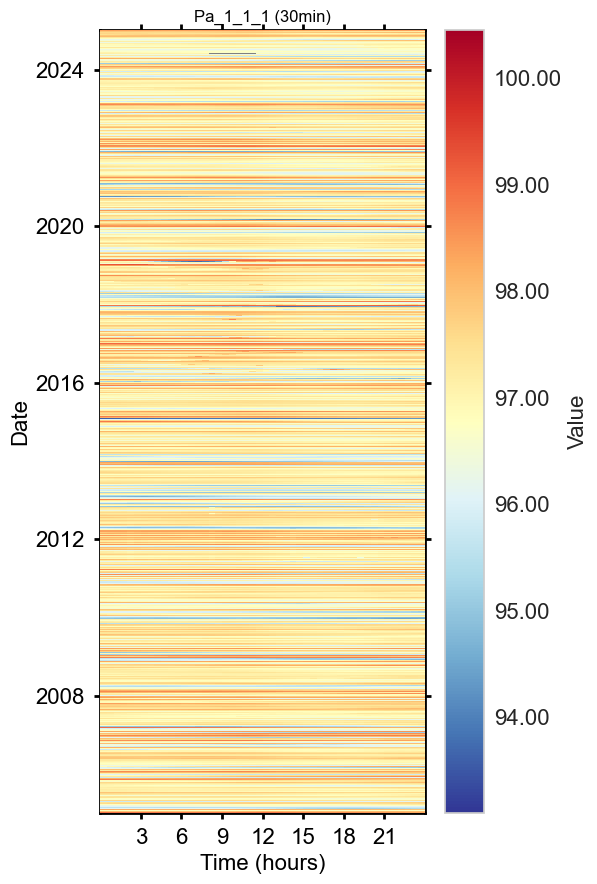

In [34]:
for col in _plot_df.columns:    
    series = _plot_df[col]
    series.name = col
    HeatmapDateTime(series, figsize=(6,9)).show()    

</br>

# **Stats**

In [35]:
data_simple_merged.describe()

,Lwin_1_1_1,Pa_1_1_1,PPFD_1_1_1,RH_1_1_1,Rg_1_1_1,Ta_1_1_1,Rg_1_1_1_gfXG,Ta_1_1_1_gfXG,PPFD_1_1_1_gfXG
count,350627.000000,350625.000000,333952.000000,282149.000000,350627.000000,350615.000000,350640.000000,350640.000000,350640.000000
mean,323.490219,97.086400,279.286305,85.712083,141.965870,9.935086,141.979494,9.935785,282.189348
std,44.121429,0.774800,464.909510,18.651722,233.934588,8.445942,233.942058,8.446144,465.744596
min,162.974000,93.097000,-24.975600,9.561100,0.000000,-18.246000,0.000000,-18.246000,-24.975600
25%,296.000500,96.671000,0.000000,75.080000,0.000000,3.260000,0.000000,3.261000,0.000000
50%,326.284000,97.116868,7.931250,95.714000,3.443000,9.660000,3.443776,9.661000,8.303900
75%,355.000000,97.567000,366.431000,99.920400,190.058500,15.915000,190.126500,15.915000,377.216250
max,454.942000,100.449000,2233.030000,100.000000,1098.310000,36.349000,1098.310000,36.349000,2233.030000


</br>

# **Keep relevant columns**

In [36]:
data_simple_merged.columns

Index(['Lwin_1_1_1', 'Pa_1_1_1', 'PPFD_1_1_1', 'RH_1_1_1', 'Rg_1_1_1', 'Ta_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1_gfXG', 'PPFD_1_1_1_gfXG'], dtype='object')

In [37]:
keepcols = ['Lwin_1_1_1', 'RH_1_1_1', 'Pa_1_1_1', 'Rg_1_1_1_gfXG', 'Ta_1_1_1_gfXG', 'PPFD_1_1_1_gfXG']
data_simple_merged = data_simple_merged[keepcols].copy()
data_simple_merged

,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1_gfXG,Ta_1_1_1_gfXG,PPFD_1_1_1_gfXG
TIMESTAMP_END,,,,,,
2005-01-01 00:30:00,331.462000,NaN,98.160000,0.0,2.241000,-0.269498
2005-01-01 01:00:00,331.462000,NaN,98.163000,0.0,2.273000,-0.269498
2005-01-01 01:30:00,330.270000,NaN,98.167000,0.0,2.305000,-0.269498
2005-01-01 02:00:00,330.270000,NaN,98.173000,0.0,2.284000,-0.269498
2005-01-01 02:30:00,323.555000,NaN,98.180000,0.0,2.264000,-0.269498
...,...,...,...,...,...,...
2024-12-31 22:00:00,304.613900,99.99799,98.337089,0.0,-1.919472,0.000000
2024-12-31 22:30:00,303.039890,99.99799,98.305216,0.0,-2.104678,0.000000
2024-12-31 23:00:00,302.093633,99.99799,98.285114,0.0,-2.089444,0.000000


</br>

# **Add timestamp columns for EddyPro**

In [38]:
# EddyPro needs two columns: date and time
data_simple_merged['date'] = data_simple_merged.index.date
data_simple_merged['date'] = data_simple_merged['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

data_simple_merged['time'] = data_simple_merged.index.time
data_simple_merged['time'] = data_simple_merged['time'].apply(lambda x: x.strftime('%H:%M'))

# Move date and time columns to start of dataframe
col = data_simple_merged.pop('date')
data_simple_merged.insert(0, col.name, col)
col = data_simple_merged.pop('time')
data_simple_merged.insert(1, col.name, col)

data_simple_merged

,date,time,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1_gfXG,Ta_1_1_1_gfXG,PPFD_1_1_1_gfXG
TIMESTAMP_END,,,,,,,,
2005-01-01 00:30:00,2005-01-01,00:30,331.462000,NaN,98.160000,0.0,2.241000,-0.269498
2005-01-01 01:00:00,2005-01-01,01:00,331.462000,NaN,98.163000,0.0,2.273000,-0.269498
2005-01-01 01:30:00,2005-01-01,01:30,330.270000,NaN,98.167000,0.0,2.305000,-0.269498
2005-01-01 02:00:00,2005-01-01,02:00,330.270000,NaN,98.173000,0.0,2.284000,-0.269498
2005-01-01 02:30:00,2005-01-01,02:30,323.555000,NaN,98.180000,0.0,2.264000,-0.269498
...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,2024-12-31,22:00,304.613900,99.99799,98.337089,0.0,-1.919472,0.000000
2024-12-31 22:30:00,2024-12-31,22:30,303.039890,99.99799,98.305216,0.0,-2.104678,0.000000
2024-12-31 23:00:00,2024-12-31,23:00,302.093633,99.99799,98.285114,0.0,-2.089444,0.000000


</br>

# **Add units for EddyPro input file**

In [39]:
renaming_dict = {
    'date': ('date', 'yyyy-mm-dd'),
    'time': ('time', 'HH:MM'),
    'Lwin_1_1_1': ('Lwin_1_1_1', 'W+1m-2'),
    'PPFD_1_1_1_gfXG': ('PPFD_1_1_1', 'umol+1m-2s-1'),
    'RH_1_1_1': ('RH_1_1_1', '%'),
    'Rg_1_1_1_gfXG': ('Rg_1_1_1', 'W+1m-2'),
    'Ta_1_1_1_gfXG': ('Ta_1_1_1', 'C'),
    'Pa_1_1_1': ('Pa_1_1_1', 'kPa')
}
data_simple_merged = data_simple_merged.rename(columns=renaming_dict)
data_simple_merged.columns = pd.MultiIndex.from_tuples(data_simple_merged.columns)
data_simple_merged

,date,time,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1,Ta_1_1_1,PPFD_1_1_1
,yyyy-mm-dd,HH:MM,W+1m-2,%,kPa,W+1m-2,C,umol+1m-2s-1
TIMESTAMP_END,,,,,,,,
2005-01-01 00:30:00,2005-01-01,00:30,331.462000,NaN,98.160000,0.0,2.241000,-0.269498
2005-01-01 01:00:00,2005-01-01,01:00,331.462000,NaN,98.163000,0.0,2.273000,-0.269498
2005-01-01 01:30:00,2005-01-01,01:30,330.270000,NaN,98.167000,0.0,2.305000,-0.269498
2005-01-01 02:00:00,2005-01-01,02:00,330.270000,NaN,98.173000,0.0,2.284000,-0.269498
2005-01-01 02:30:00,2005-01-01,02:30,323.555000,NaN,98.180000,0.0,2.264000,-0.269498
...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,2024-12-31,22:00,304.613900,99.99799,98.337089,0.0,-1.919472,0.000000
2024-12-31 22:30:00,2024-12-31,22:30,303.039890,99.99799,98.305216,0.0,-2.104678,0.000000


</br>

# **Set missing values code** to -9999

In [40]:
# EddyPro needs missing values as -9999
data_simple_merged = data_simple_merged.fillna(-9999)
data_simple_merged

,date,time,Lwin_1_1_1,RH_1_1_1,Pa_1_1_1,Rg_1_1_1,Ta_1_1_1,PPFD_1_1_1
,yyyy-mm-dd,HH:MM,W+1m-2,%,kPa,W+1m-2,C,umol+1m-2s-1
TIMESTAMP_END,,,,,,,,
2005-01-01 00:30:00,2005-01-01,00:30,331.462000,-9999.00000,98.160000,0.0,2.241000,-0.269498
2005-01-01 01:00:00,2005-01-01,01:00,331.462000,-9999.00000,98.163000,0.0,2.273000,-0.269498
2005-01-01 01:30:00,2005-01-01,01:30,330.270000,-9999.00000,98.167000,0.0,2.305000,-0.269498
2005-01-01 02:00:00,2005-01-01,02:00,330.270000,-9999.00000,98.173000,0.0,2.284000,-0.269498
2005-01-01 02:30:00,2005-01-01,02:30,323.555000,-9999.00000,98.180000,0.0,2.264000,-0.269498
...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,2024-12-31,22:00,304.613900,99.99799,98.337089,0.0,-1.919472,0.000000
2024-12-31 22:30:00,2024-12-31,22:30,303.039890,99.99799,98.305216,0.0,-2.104678,0.000000


</br>

# **Save to file**

In [41]:
data_simple_merged.to_csv(OUTFILE, index=False)

</br>

# **End of notebook**.

In [42]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-01-22 14:31:34


</br>

# (Bonus)

In [ ]:
# ta = data_simple_merged[('Ta_1_1_1', 'C')].copy()
# ta = TimestampSanitizer(data=ta).get()
# ta = ta.loc[ta.index.year > 2005].copy()
# means = ta.groupby(ta.index.year).mean()
# means

In [ ]:
# means.sort_values(ascending=False).head(5)

In [ ]:
# means.loc[means.index > 2014].mean()